## Grad-CAM demo

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import urllib.request
import numpy as np

from torchvision import models, datasets, transforms
from PIL import Image
import cv2

from gradcam import GradCAM

%matplotlib inline

### Download the Model
To test the performance of our Grad-CAM implementation, we will use a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [ ]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

### Download ImageNet labels
Now we download all the labels present in the ImageNet dataset. 

In [11]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We will test our implementation on 20 images. In order to use the pretrained model resnet50, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [12]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [13]:
dir_path = "data/" 
dataset = preprocess_image(dir_path)

### Run the demo

['African elephant, Loxodonta africana', 'Indian elephant, Elephas maximus', 'tusker']


c:\ProgramData\anaconda3\envs\DeepLearning\Lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


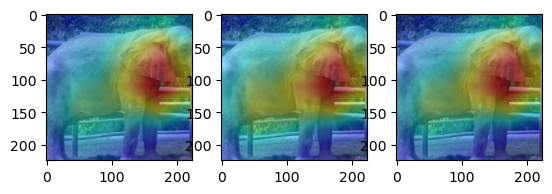

['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']


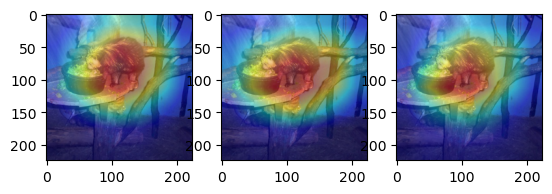

['Tibetan terrier, chrysanthemum dog', 'Old English sheepdog, bobtail', 'Shih-Tzu']


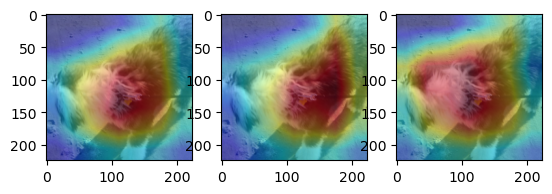

['Norwegian elkhound, elkhound', 'Cardigan, Cardigan Welsh corgi', 'German shepherd, German shepherd dog, German police dog, alsatian']


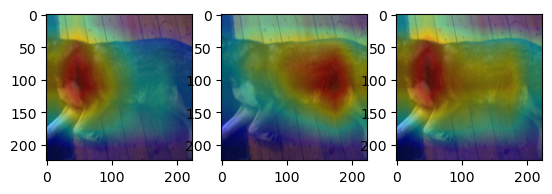

['English springer, English springer spaniel', 'Welsh springer spaniel', 'Sussex spaniel']


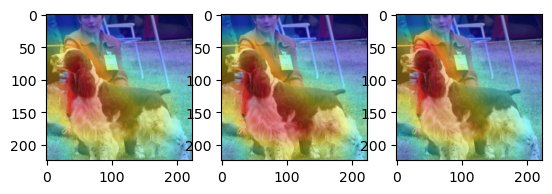

['Egyptian cat', 'tabby, tabby cat', 'tiger cat']


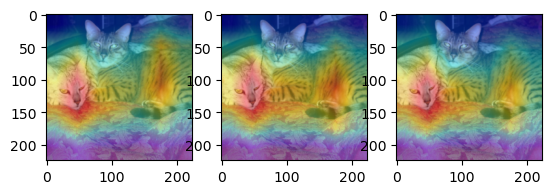

['Arctic fox, white fox, Alopex lagopus', 'kit fox, Vulpes macrotis', 'grey fox, gray fox, Urocyon cinereoargenteus']


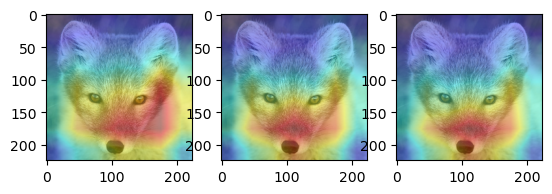

['Great Dane', 'Labrador retriever', 'Chesapeake Bay retriever']


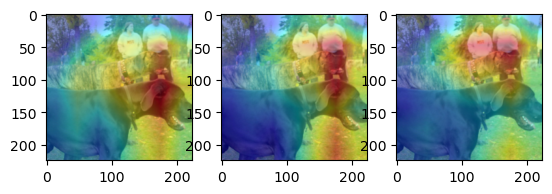

['weasel', 'mink', 'otter']


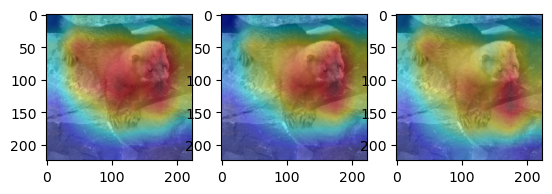

['ibex, Capra ibex', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'ram, tup']


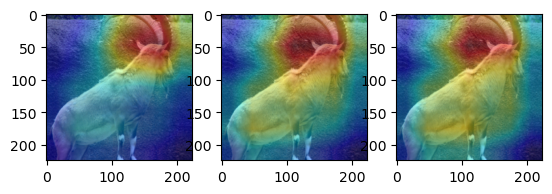

['sorrel', 'ox', 'basenji']


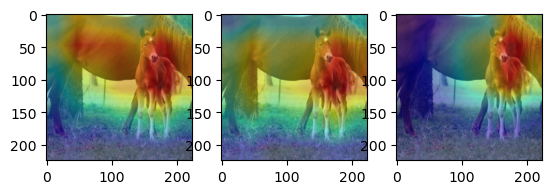

['red wolf, maned wolf, Canis rufus, Canis niger', 'kit fox, Vulpes macrotis', 'red fox, Vulpes vulpes']


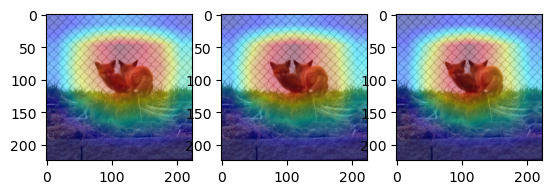

['European gallinule, Porphyrio porphyrio', 'mink', 'scorpion']


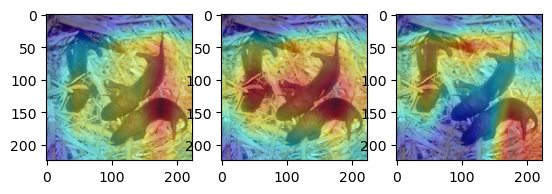

['impala, Aepyceros melampus', 'gazelle', 'wallaby, brush kangaroo']


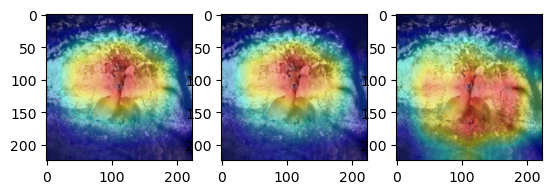

['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'lynx, catamount']


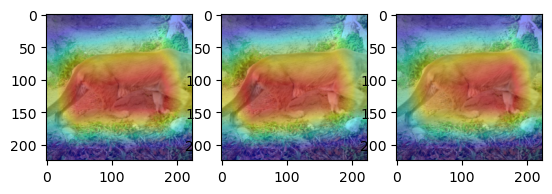

['sea lion', 'cowboy boot', 'balance beam, beam']


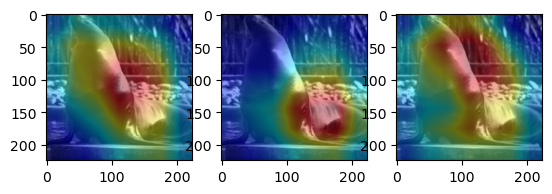

['titi, titi monkey', 'howler monkey, howler', 'gibbon, Hylobates lar']


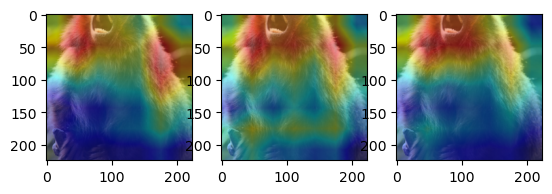

['lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'polecat, fitch, foulmart, foumart, Mustela putorius', 'weasel']


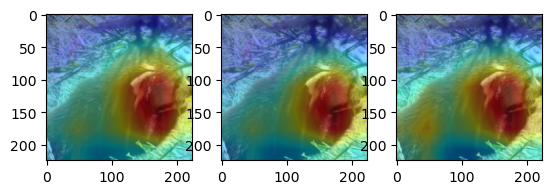

['marmoset', 'three-toed sloth, ai, Bradypus tridactylus', 'fox squirrel, eastern fox squirrel, Sciurus niger']


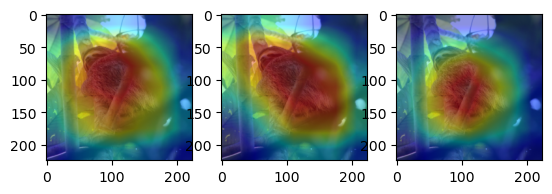

['squirrel monkey, Saimiri sciureus', 'titi, titi monkey', 'spider monkey, Ateles geoffroyi']


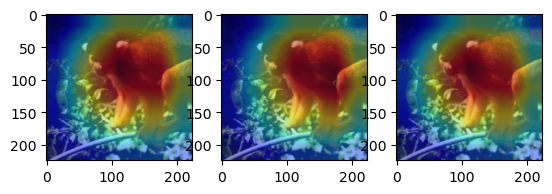

In [15]:
for image_index in range(len(dataset)):
    input = dataset[image_index][0].view(1, 3, 224, 224)

    output = resnet34(input)
    values, indices = torch.topk(output, 3)
    classes_on_the_pic = [classes[x] for x in indices[0].numpy()]
    gradcam = GradCAM(resnet34, resnet34.layer4[2].conv2)

    print(classes_on_the_pic)

    plt.figure()
    for i in range(3):
        plt.subplot(1, 3, i+1)
        indice = indices[0][i].item()
        heatmap = gradcam(input, indice)
        plt.imshow(heatmap)
    plt.show()

We can see that depending on the desired class, the heatmap highlights different zones of a given image.

In this dataset there is only one animal on each image so the results are quite similar between each other but if we used the Grad-CAM technique on an image containing a cat and a dog for example, the heatmap would highlight very different zones of the image.

### Impact of network depth on grad-CAM capabilities

Let's try Grad-CAM on others convolutional layers from the shallowest to the deepest.

['Egyptian cat']


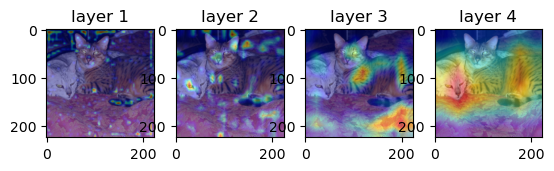

In [16]:
image_index = 5
input = dataset[image_index][0].view(1, 3, 224, 224)

output = resnet34(input)
values, indices = torch.topk(output, 1)
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))
classes = [classes[x] for x in indices[0].numpy()]
gradcam1 = GradCAM(resnet34, resnet34.layer1[2].conv2)
gradcam2 = GradCAM(resnet34, resnet34.layer2[3].conv2)
gradcam3 = GradCAM(resnet34, resnet34.layer3[5].conv2)
gradcam4 = GradCAM(resnet34, resnet34.layer4[2].conv2)

print(classes)
indice = indices[0][0].item()

plt.figure()
plt.subplot(1, 4, 1)
heatmap1 = gradcam1(input, indice)
plt.title("layer 1")
plt.imshow(heatmap1)

plt.subplot(1, 4, 2)
heatmap2 = gradcam2(input, indice)
plt.title("layer 2")
plt.imshow(heatmap2)

plt.subplot(1, 4, 3)
heatmap3 = gradcam3(input, indice)
plt.title("layer 3")
plt.imshow(heatmap3)

plt.subplot(1, 4, 4)
heatmap1 = gradcam4(input, indice)
plt.title("layer 4")
plt.imshow(heatmap1)

plt.show()

We can see that in the first convolutional layer, we can't understand the patterns the model use for the classification tasks with the naked eye as it highlights features such as edges and corners only. The deeper we go into the ResNet model the more understandable the patterns become, as they become more complex and abstract features. 

For greater interpretability, using the last convolutional layers as target layer is more relevant as they highlight visual patterns that make more sense for us humans.